# Import libraries

In [1]:
%load_ext autoreload
%autoreload 1

In [83]:
# Import basic libraries
import re
import os
import pandas as pd
import numpy as np
from collections import Counter
import copy
import ast

# Import libraries for plotting
import matplotlib.pyplot as plt
import plotly.express as px
from wordcloud import WordCloud

# Import libraries for text processing
## Import libraries for Spacy
import spacy
from spacy import displacy
from spacy.tokens import Span
from spacy.matcher import Matcher 

## Import transformers and others
from sentence_transformers import SentenceTransformer, SimilarityFunction, util
from transformers import AutoTokenizer, AutoModelForTokenClassification

# Import libraries for clustering
import umap.umap_ as umap
from bertopic.vectorizers import ClassTfidfTransformer


In [3]:
# Check CUDA on torch
import torch
print(torch.cuda.is_available())  # Should return True if CUDA is properly installed
print(torch.cuda.current_device())  # Returns the index of the current CUDA device
print(torch.cuda.get_device_name(torch.cuda.current_device())) 

True
0
NVIDIA GeForce RTX 3060 Laptop GPU


In [4]:
# Import pycountry
import pycountry
import pycountry_convert as pc

In [5]:
# Import own libraries
from _extract_info import extract_abstracts_bib

from _clustering_BERT import BERTopic_model, silhouette_score_calc, BERTopic_best_params, plot_silhouette_score

# USE:      BERTopic_model(docs, embeddings, n_comp=20, n_neigh=25, minS_cluster=5)
# RETURN:   topics, probs, topic_model

# USE:      silhouette_score_calc(embeddings, topics)
# RETURN:   silhouette_avg, negative_topics

#USE:       BERTopic_best_params(docs, embeddings, n_ClusterSize, n_comp_matrix, n_neigh_matrix)
#RETURN:    DataFrame with parameters and scores

#USE:       plot_silhouette_score(embedings_x, topics)
#RETURN:    Plot of silhouette scores

In [6]:
%aimport _extract_info
%aimport _clustering_BERT

# Import information

## Load the data extracted

In [5]:
# Create the excel file with the abstracts information
bib_directory   = '00_bibFiles'
bib_file        = 'search_003'
path_export     = extract_abstracts_bib(bib_file, bib_directory,'out_rev')

The bib file search_003 was exported successfully with 7794 entries.


In [8]:
# From the extracted information, create a dataframe
bib_file        = 'search_003'
path_export_file = os.path.join('out_rev', bib_file+'_export.xlsx')
df_base = pd.read_excel(path_export_file)
print(df_base.columns)
print(df_base.shape)

Index(['author', 'title', 'year', 'journal', 'url', 'doi', 'abstract',
       'author_keywords', 'keywords', 'type', 'publication_stage', 'source',
       'note'],
      dtype='object')
(7794, 13)


## Data preprocess
While using a parser provided by SentenceTransforomers there is no need to clearing the data since the model is already trained, however will be dicarted the abstracts that are far away 3STD from the mean. Finally the remaining abstracts longer than 512 tokens will be truncated by the parser.

In [9]:
# Filter out rows with missing abstracts or titles
shape_0 = df_base.shape[0]
df_base = df_base.dropna(subset=['abstract', 'title'])
df_base = df_base[df_base['abstract'] != 'NoData']
df_base = df_base[df_base['title'] != 'NoData']

df_base = df_base.reset_index(drop=True)

# Print how many rows were removed
print(f"Removed {shape_0 - df_base.shape[0]} rows with missing data")

# Create a new dataframe with the abstracts to analyze
df_analyze = df_base[['title', 'abstract']].copy()
df_analyze['id_base'] = df_base.index


Removed 4 rows with missing data


In [12]:

# Import model for tokenization
model_name  = 'sentence-transformers/all-MiniLM-L6-v2'
tokenizer   = AutoTokenizer.from_pretrained(model_name)
embedding_model = SentenceTransformer(model_name)

# Tokenize the abstracts
df_analyze['tokens'] = df_analyze['abstract'].apply(lambda x: tokenizer.encode(x))

# Plot the number of  tokens and check how many are higher than 512
df_analyze['token_length'] = df_analyze['tokens'].apply(lambda x: len(x))

# Plot the number of tokens with plotty
fig = px.histogram(df_analyze, x='token_length', nbins=50)
fig.update_layout(title='Number of tokens in abstracts')
fig.show()

print('Abstracts that exceeds 512 tokens:', len(df_analyze[df_analyze['token_length']>=512]))

Token indices sequence length is longer than the specified maximum sequence length for this model (559 > 512). Running this sequence through the model will result in indexing errors


Abstracts that exceeds 512 tokens: 228


In [13]:
# Find the STD of the number of tokens
mean_tokens = df_analyze['token_length'].mean()
std_tokens  = df_analyze['token_length'].std()

# Drop the abstracts that are of the range of 3 standard deviations
shape_1 = df_analyze.shape[0]
df_analyze = df_analyze[
                (df_analyze['token_length'] < mean_tokens + 3*std_tokens) &
                (df_analyze['token_length'] > 50)]
df_analyze = df_analyze.reset_index(drop=True)
shape_2 = df_analyze.shape[0]

print('Abstracts dropped:', shape_1 - shape_2)

Abstracts dropped: 82


In [16]:
df_analyze['base_idx'] = df_analyze.index
df_analyze.reset_index(drop=True, inplace=True)
# Save the dataframe
df_analyze.to_excel('df_analyze.xlsx', index=False)

# Clustering of topics

## Create embeddings

In [7]:
# Read the excel file
df_analyze = pd.read_excel('df_analyze.xlsx')

In [389]:
# Embedding model using the MiniLM model
embedding_model = SentenceTransformer("all-MiniLM-L6-v2", device='cuda')

# Create embedding of abstracts

df_analyze['specter'] = df_analyze.apply(lambda x: x['title']+' '+x['abstract'], axis=1)
abstracts = df_analyze['specter']
embeddings_MiniLM = embedding_model.encode(abstracts, show_progress_bar=True)

Batches:   0%|          | 0/241 [00:00<?, ?it/s]

## Find the best parameters for clustering
- Parameters to evaluate: 
    - For dimension reduction with UMAP changing (neighbors size and number of components)
    - For HDBSCAN the minimum size of the cluster

In [20]:
# Embeddings to use
embedings_x     = embeddings_MiniLM

# Define the number of components, neighbors and minimum cluster size
n_ClusterSize   = [15, 20]
n_comp_matrix   = [10, 20, 50, 100]
n_neigh_matrix  = [20, 50, 100]

best_params = BERTopic_best_params(abstracts, embedings_x, n_ClusterSize, n_comp_matrix, n_neigh_matrix)


## Clustering of Topics
From the previous step the parameters chosen are:

Silhouette score: 0.06226298213005066


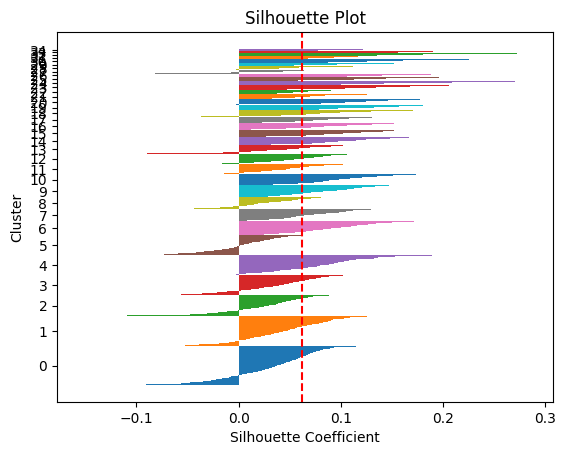

In [86]:
# Embeddings to use
embedings_x     = embeddings_MiniLM

# Selected parameters
## Good parameters including titles: 20, 40, 60 Score:0.06226
## MiniLM:  20, 20, 50
_minCluster = 20
_components = 40
_neighbors  = 60

# Fit the BERTopic model
topics, probs, topic_model = BERTopic_model(
                                abstracts,
                                embedings_x, 
                                n_comp        = _components, 
                                n_neigh       = _neighbors, 
                                minS_cluster  = _minCluster,
                                )
silhouette_avg, negative_topics = silhouette_score_calc(embedings_x, topics)
print(f"Silhouette score: {silhouette_avg}")

# Plot the silhouette score
plot_silhouette_score(embedings_x, topics)

In [87]:
# Reduce embeddings to 2D for visualization
reduced_embeddings = umap.UMAP( n_neighbors=_neighbors, n_components=2, 
                          min_dist=0.0, metric='cosine').fit_transform(embedings_x)

# Get the abstracts information from the topic model
document_info = topic_model.get_document_info(abstracts)

# Visualize the topics
topic_model.visualize_documents(abstracts, reduced_embeddings=reduced_embeddings, 
                                hide_document_hover=True, hide_annotations=True)


In [93]:
# Reduce outliers
new_topics = topic_model.reduce_outliers(abstracts, topics, probabilities=probs, 
                             threshold=0.1, strategy="probabilities")

#new_topics = topic_model.reduce_outliers(abstracts, topics, strategy="embeddings", threshold=0.1)

# Use the "c-TF-IDF" strategy with a threshold
#new_topics = topic_model.reduce_outliers(abstracts, topics , strategy="c-tf-idf", threshold=0.05)

# Reduce all outliers that are left with the "distributions" strategy
#new_topics = topic_model.reduce_outliers(abstracts, topics, strategy="distributions", threshold=0.1)

topic_model.update_topics(abstracts, topics=new_topics)
document_info = topic_model.get_document_info(abstracts)
topic_model.visualize_documents(abstracts, reduced_embeddings=reduced_embeddings, 
                                hide_document_hover=True, hide_annotations=True)

2024-09-12 12:15:30,054 - BERTopic - WARNING: Using a custom list of topic assignments may lead to errors if topic reduction techniques are used afterwards. Make sure that manually assigning topics is the last step in the pipeline.Note that topic embeddings will also be created through weightedc-TF-IDF embeddings instead of centroid embeddings.


In [94]:
# Save the model
path_model = os.path.join('out_rev', 'topic_model')
embedding_model = "sentence-transformers/all-MiniLM-L6-v2"
topic_model.save(path_model, serialization="safetensors", save_ctfidf=True, save_embedding_model=embedding_model)

# Add to df_analyze the topics
df_analyze['topic'] = topics

## Reduction of topics
Analyzing the cluster manually start to discard cluster not revelant to the thesis topic and then start reducing the topics by joining close topics

### Extract questions for GPT

In [17]:
repr_doc = document_info[['Topic','KeyBert', 'Representative_Docs']]
repr_doc = repr_doc[repr_doc['Topic']!= -1]
repr_doc = repr_doc.drop_duplicates(subset=['Topic'])

def prompt_GPT(documents, keywords):
    
    _documents  = '- '+'\n- '.join(documents)  
    _keywords   = ', '.join(keywords)
    
    prompt = """
I have a topic that contains the following documents: 
[DOCUMENTS]

The topic is described by the following keywords: [KEYWORDS]

Based on the information above, extract a short topic label in the following format:
topic: <topic label>
"""
    return prompt.replace('[DOCUMENTS]', _documents).replace('[KEYWORDS]', _keywords)

repr_doc['Prompt'] = repr_doc.apply(lambda x: prompt_GPT(x['Representative_Docs'], x['KeyBert']), axis=1)
repr_doc.to_excel('repr_doc.xlsx', index=False)


### Import topic labels

In [372]:
# Read BERToptic model
from bertopic import BERTopic
path_model = os.path.join('out_rev', 'topic_model')
topic_model = BERTopic.load(path_model)

# Reduce embeddings to 2D for visualization
embedings_x = embeddings_MiniLM
reduced_embeddings = umap.UMAP( n_neighbors=50, n_components=2, 
                          min_dist=0.0, metric='cosine').fit_transform(embedings_x)

In [513]:
# Read the excel to df_analyze
path_file = os.path.join('out_rev', 'topics_ChatGPT.xlsx')

repr_doc = pd.read_excel(path_file)
repr_doc['Representative_Docs'] = repr_doc['Representative_Docs'].apply(ast.literal_eval)
repr_doc['KeyBert'] = repr_doc['KeyBert'].apply(ast.literal_eval)

# Update the topics with the column ChatGPT
GPT_topics = repr_doc[['Topic', 'ChatGPT', 'short_label', 'priority']].copy()

GPT_topics['priority'] = GPT_topics['priority'].astype(str)  # Ensure priority is a string

GPT_topics['topic_label'] = GPT_topics['ChatGPT'].apply(lambda x: x.split('topic: ')[1])

GPT_topics['topic_label'] = GPT_topics.apply(lambda x: '['+ x['priority'] + '] ' + x['topic_label'], axis=1)
GPT_topics['short_label'] = GPT_topics.apply(lambda x: '['+ x['priority'] + '] ' + x['short_label'], axis=1)

GPT_topics = GPT_topics.sort_values(by='Topic')

topic_labels = dict(zip(GPT_topics['Topic'], GPT_topics['topic_label']))
short_labels = dict(zip(GPT_topics['Topic'], GPT_topics['short_label']))


## Plotting results of clusters

In [489]:
# Visualize the topics
topic_model.set_topic_labels(short_labels)
topic_model.visualize_documents(abstracts , reduced_embeddings=reduced_embeddings,
                                hide_document_hover=True, hide_annotations=True,
                                custom_labels=True, height=850, width=1200)

In [514]:
# Plot hyrarchy
topic_model.set_topic_labels(short_labels)
topic_model.visualize_hierarchy(custom_labels=True)

In [516]:
# Plot heatmap
topic_model.set_topic_labels(short_labels)
topic_model.visualize_heatmap( custom_labels=True, height=800, width=900)

In [518]:
# Extract the topics and their labels
topics_f = GPT_topics['Topic'].tolist()
labels_f = GPT_topics['topic_label'].tolist()

# Filter the topics that include '[2]' in their labels
filtered_topics = [topic for topic, label in zip(topics_f, labels_f) if '[0]' in label]

# Visualize the heatmap using the filtered topics
topic_model.visualize_heatmap(
    topics=filtered_topics,
    custom_labels=True,
    height=800,
    width=1000
)

In [494]:
# Visualize the topics by year
# Read the excel file base
bib_file        = 'search_003'
path_export_file = os.path.join('out_rev', bib_file+'_export.xlsx')
df_base = pd.read_excel(path_export_file)

# Join the df_base with the df_analyze
df_analyze = df_analyze.merge(df_base[['year']], left_on='id_base', right_index=True)   


In [521]:
# Plot the topics by year
df_by_year = df_analyze.groupby(['year_x', 'topic']).size().reset_index(name='count')
df_by_year = df_by_year[df_by_year['topic'] != -1]
# Change name of columns
df_by_year.rename(columns={'year_x': 'year'}, inplace=True)

# Join GPT_topics with df_by_year
df_by_year = df_by_year.merge(GPT_topics[['Topic', 'topic_label', 'short_label', 'priority']], left_on='topic', right_on='Topic')
df_by_year = df_by_year[df_by_year['priority'] != '0']
df_by_year = df_by_year[df_by_year['year'] >= 2014]

# Create the line plot
fig = px.line(df_by_year, x='year', y='count', color='short_label', title='Topics by Year - Priority [1, 2]', markers=True)

# Get the last data points to place labels
for short_label in df_by_year['short_label'].unique():
    df_label = df_by_year[df_by_year['short_label'] == short_label]
    x_label = df_label['year'].max()  # Get the last year
    y_label = df_label[df_label['year'] == x_label]['count'].values[0]  # Get the corresponding count

    # Add annotation at the end of each line
    fig.add_annotation(
        x=x_label, y=y_label,
        text=short_label,
        showarrow=False,
        xanchor='left',
        font=dict(color='black', size=12)
    )

# Remove legend since we are adding labels directly on the plot
fig.update_layout(showlegend=False)
fig.update_xaxes(title_text='Year')

# Center the title and black
fig.update_layout(title_x=0.5, title_font=dict(size=25), title_font_color='black')
fig.update_yaxes(title_text='Number of Papers')
fig.update_layout(width=1200, height=800)

# Show the plot
fig.show()

## Clustering of outliers

In [174]:
df_ouliers = df_analyze[df_analyze['topic']==-1]
df_ouliers = df_ouliers.reset_index(drop=True)

# Calcuate embeddings for the outliers
embedding_model = SentenceTransformer("all-MiniLM-L6-v2", device='cuda')

abstracts = df_ouliers['abstract']
embeddings_outliers = embedding_model.encode(abstracts, show_progress_bar=True)

Batches:   0%|          | 0/122 [00:00<?, ?it/s]

Silhouette score: 0.046990033239126205


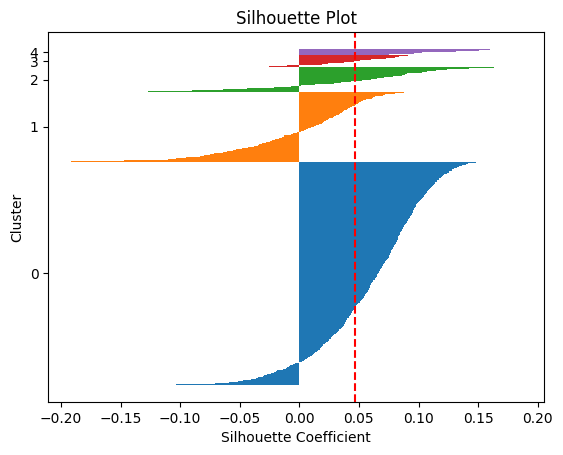

In [204]:
# Embeddings to use
embedings_x     = embeddings_outliers

# Selected parameters
#50 30 100 Score:0.08

_minCluster = 30
_components = 30
_neighbors  = 100

# Fit the BERTopic model
topics, probs, topic_model = BERTopic_model(
                                abstracts,
                                embedings_x, 
                                n_comp        = _components, 
                                n_neigh       = _neighbors, 
                                minS_cluster  = _minCluster,
                                )
silhouette_avg, negative_topics = silhouette_score_calc(embedings_x, topics)
print(f"Silhouette score: {silhouette_avg}")

# Plot the silhouette score
plot_silhouette_score(embedings_x, topics)

In [206]:
# Reduce embeddings to 2D for visualization
#reduced_embeddings = umap.UMAP( n_neighbors=_neighbors, n_components=2, 
#                          min_dist=0.0, metric='cosine').fit_transform(embedings_x)

# Get the abstracts information from the topic model
document_info = topic_model.get_document_info(abstracts)

# Visualize the topics
topic_model.visualize_documents(abstracts, reduced_embeddings=reduced_embeddings, 
                                hide_document_hover=True, hide_annotations=True)


In [207]:
# Add to df_analyze the topics
df_ouliers['topic'] = topics

## Save the results

In [208]:
# Save the outliers
path_file = os.path.join('out_rev', 'df_ouliers_topics.xlsx')
df_ouliers.to_excel(path_file, index=False)

# Save the df_analyze
path_file = os.path.join('out_rev', 'df_analyze_topics.xlsx')
df_analyze.to_excel(path_file, index=False)

# Extract features

In [12]:
path_export = os.path.join('out_rev', 'abstracts_topics.xlsx')
df_analyze = pd.read_excel(path_export)

## Extract Countries

In [15]:
# Extract entities using the wikineural-multilingual-ner model

tokenizer   = AutoTokenizer.from_pretrained("Babelscape/wikineural-multilingual-ner")
model       = AutoModelForTokenClassification.from_pretrained("Babelscape/wikineural-multilingual-ner")

nlp = pipeline("ner", model=model, tokenizer=tokenizer, grouped_entities=True, device=0)

# Extract entities from the abstracts
df_analyze['entities'] = df_analyze['abstract'].apply(lambda x: nlp(x))

# Extract entities from the title
df_analyze['entities_title'] = df_analyze['title'].apply(lambda x: nlp(x))

# Get a column with LOC entities
df_analyze['LOC'] = df_analyze.apply(lambda x: [entity['word'] for entity in (x['entities']+x['entities_title']) if entity['entity_group'] == 'LOC'], axis=1)
df_analyze['LOC'] = df_analyze['LOC'].apply(lambda x: list(set(x)))

You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


### Get the countries

In [140]:
def get_country_code(location):
    try:
        # Attempt to match the location as a country name
        country = pycountry.countries.lookup(location)
        return country.alpha_2
    except LookupError:
        pass
    
    try:
        # If not a country, check if it's a subdivision
        subdivision = pycountry.subdivisions.lookup(location)
        country = pycountry.countries.get(alpha_2=subdivision.country_code)
        return country.alpha_2
    except LookupError:
        return None

# Create a new dataframe with the LOC entities for cleaning
df_loc = df_analyze.explode('LOC')
df_loc = df_loc.groupby(['LOC']).size().reset_index(name='count')

# Apply the function to get country codes
df_loc['country_code'] = df_loc['LOC'].apply(lambda x: get_country_code(x) if x else None)

# Export the results for cleaning
path_export = os.path.join('out', 'locations.xlsx')
df_loc.to_excel(path_export, index=False)

In [221]:
# Import the excel with the country codes
path_export = os.path.join('out_rev', 'locations_clean.xlsx')
df_loc = pd.read_excel(path_export)

# Filter out rows with missing country codes
df_loc = df_loc.dropna(subset=['country_code'])

# Function to find the country code for a list of locations
def get_country_codes(loc_list, df_loc):
    country_codes = []
    for loc in loc_list:
        # Check if the location is in df_loc and get the corresponding country code
        matching_row = df_loc[df_loc['LOC'] == loc]
        if not matching_row.empty:
            country_codes.append(matching_row['country_code'].values[0])

    return country_codes

# Apply the function to the LOC column in df_analyze
df_analyze['country_code'] = df_analyze['LOC'].apply(lambda x: get_country_codes(x, df_loc) if isinstance(x, list) else [])
df_analyze['country_code'] = df_analyze['country_code'].apply(lambda x: list(set(x)))
df_analyze['n_countries'] = df_analyze['country_code'].apply(lambda x: len(x))


### Get the continents

In [296]:
# Mapping of continent codes to continent names
region_names = {
    'AF': 'Africa',
    'AS': 'Asia',
    'EU': 'Europe',
    'NA': 'North America',
    'SA': 'South America',
    'OC': 'Oceania',
    'ME': 'Middle East'  # Custom region for Middle East
}

# Lists of country codes for custom regions

## Create a Middle East region
middle_east_countries = {'EG', 'IR', 'IQ', 'JO', 'LB', 'OM', 'PS', 'QA', 'SA', 'SY', 'TR', 'AE', 'YE'}
ME_countries = {}
for country_code in middle_east_countries:
    ME_countries[country_code] = 'ME'

## Custom list mapping some countries to continents
custom_list = {    
    'Asia': 'AS', 
    'Europe': 'EU',
    'Africa': 'AF',
    'North America': 'NA',
    'South America': 'SA',
    'Middle East': 'ME',
    'BlackSea': 'EU',
    }

## List with the custom regions
custom_list.update(ME_countries)


# Function to get the continent or custom region name
def get_continent_region(country_code):
    # Check in the custom list first
    if country_code in custom_list:
        continent_code = custom_list[country_code]
    else:
        # If not in custom list, use pycountry_convert
        try:
            continent_code = pc.country_alpha2_to_continent_code(country_code)
        except KeyError:
            return None  # Return None if the country code is not recognized
    
    # Convert the continent code to a continent name
    return region_names.get(continent_code, 'Unknown')


In [ ]:

# Apply the function to the country_code column
df_analyze['continent'] = df_analyze['country_code'].apply(
    lambda x: [get_continent_region(code) for code in x] if isinstance(x, list) else []
)
df_analyze['continent'] = df_analyze['continent'].apply(lambda x: list(set(x)))
df_analyze['n_locations']= df_analyze['LOC'].apply(lambda x: len(x) if isinstance(x, list) else 0)

### Get relations between countries

In [229]:
# Function to find the verbs with location-related prepositions
nlp = spacy.load("en_core_web_sm")

# Function to find verbs with location-related prepositions
def extract_relations(abstract, LOCs):
    for i in range(len(LOCs)):
        tag = f"LOC{i} "
        abstract = abstract.replace(LOCs[i], tag)

    doc = nlp(abstract)

    relations_dict = []
    for i in range(len(LOCs)):
        tag = f"LOC{i}"
        relations = []
        for token in doc:
            if token.pos_ == 'VERB' or token.pos_ == 'NOUN':  # Check if the token is a verb
                # Check the verb's children for a preposition followed by a location (LOC)
                for child in token.children:
                    if child.dep_ == "prep":  # Check if the child is a preposition
                        for grandchild in child.children:
                            if grandchild.text==tag:
                                relation = f"{token.lemma_.capitalize()}{child.text.capitalize()}"
                                relations.append(relation)
            if token.text == tag:
                relations.append(token.head.text)                        
        rel_LOC = {'LOC': LOCs[i], 'REL': set(relations)}
        relations_dict.append(rel_LOC)
    return relations_dict
    
df_analyze['relations'] = df_analyze.apply(lambda x: extract_relations(x['abstract'], x['LOC']), axis=1)


In [231]:
# Export the results
path_export = os.path.join('out_rev', 'abstracts_topics_entities.xlsx')
df_analyze.to_excel(path_export, index=False)

In [235]:
# Update LOC with the cleaned locations
mapping_dict = {}

original_keys = df_loc['LOC'].tolist()
standardized_keys = df_loc['country_code'].tolist()

mapping_dict.update(dict(zip(original_keys, standardized_keys)))

def rename_values(dics, mapping_dict, value_key='LOC'):
    dics_list = []
    seen_locs = {}
    for t in dics:
        if t[value_key] in mapping_dict:
            t[value_key] = mapping_dict[t[value_key]]

            if t[value_key] in seen_locs:
                dics_list[seen_locs[t[value_key]]]['REL'].update(t['REL'])
            else:
                seen_locs[t[value_key]] = len(dics_list)
                dics_list.append(t)
        
    return dics_list

# Apply the function to the relations column
df_analyze['relations'] = df_analyze['relations'].apply(lambda x: rename_values(x, mapping_dict))

In [224]:
# Create a df with the relations to be cleaned

df_filtered = df_analyze[df_analyze['n_countries'] > 1]
df_relations = df_filtered.explode('relations')
df_relations = df_relations.dropna(subset=['relations'])
df_relations['relations'] = df_relations['relations'].apply(lambda x: list(x['REL']) if isinstance(x, dict) else None)

count_relations = df_relations['relations'].tolist()
count_relations = Counter([item for sublist in count_relations for item in sublist])
count_relations = pd.DataFrame.from_dict(count_relations, orient='index').reset_index()
count_relations.columns = ['rel', 'count']
count_relations = count_relations.sort_values('count', ascending=False)

# Export the results
path_export = os.path.join('out', 'relations.xlsx')
count_relations.to_excel(path_export, index=False)
print(count_relations)

            rel  count
11           in     93
9            to     24
26         LOC0     23
33           of     20
5          LOC2     18
..          ...    ...
122   CompareTo      1
123      CostIn      1
126     emerges      1
127  ContrastTo      1
305     sampled      1

[306 rows x 2 columns]


In [237]:
# Import the excel with the relations
path_export = os.path.join('out_rev', 'relations_clean.xlsx')
clean_relations = pd.read_excel(path_export)

# Create a dictionary with the relations
clean_relations = clean_relations.dropna(subset=['FromTo'])
relations_dict = dict(zip(clean_relations['rel'], clean_relations['FromTo']))

# Function to define FROM and TO relations
def fromto_relations(dics, relations_dict, value_key='REL'):
    dict_list = []
    for t in dics:
        for val in t[value_key]:
            if val in relations_dict:
                dict_rel = {relations_dict[val]: t['LOC']}
                dict_list.append(dict_rel)
    
    result = {}
    for d in dict_list:
        for key, value in d.items():
            if key in result:
                result[key].add(value)
            else:
                result[key] = {value}
    
    # Convert the result dictionary back into a list of dictionaries
    unique_list = [{k: v} for k, v in result.items()]
    
    return unique_list

# Apply the function to the relations column
df_analyze['FromTo'] = df_analyze['relations'].apply(lambda x: fromto_relations(x, relations_dict))

In [ ]:
# Save the result
path_export = os.path.join('out_rev', 'df_analyze_locations.xlsx')
df_analyze.to_excel(path_export, index=False)

### Plot the results

In [234]:
# Import the excel with the relations
path_locations = os.path.join('out_rev', 'df_analyze_locations.xlsx')
df_analyze_loc = pd.read_excel(path_locations)

df_analyze_loc['country_code'] = df_analyze_loc['country_code'].apply(ast.literal_eval)
df_analyze_loc['continent'] = df_analyze_loc['continent'].apply(ast.literal_eval)
df_analyze_loc['relations'] = df_analyze_loc['relations'].apply(ast.literal_eval)
df_analyze_loc['FromTo'] = df_analyze_loc['FromTo'].apply(ast.literal_eval)

# Join the df_analyze with the df_analyze_loc usin id_base
df_analyze['id_base'] = df_analyze['id_base'].astype(int)
df_analyze_loc['id_base'] = df_analyze_loc['id_base'].astype(int)

#Print duplicates
print(df_analyze.duplicated(subset='id_base').sum())

# Merge the dataframes
df_analyze_loc = df_analyze_loc.merge(df_analyze[['id_base', 'title','topic']], on='id_base', how='left')

# Check if titles are the same
df_analyze_loc['check_title'] = df_analyze_loc.apply(lambda x: x['title_x'] == x['title_y'], axis=1)
print(df_analyze_loc['check_title'].value_counts())

0


In [539]:
df_region = df_analyze_loc.explode('continent')
df_region = df_region.groupby(['continent', 'topic']).size().reset_index(name='count')
df_region = df_region.sort_values('count', ascending=False)

# Incidences by topic
df_region['total'] = df_region.groupby('topic')['count'].transform('sum')
df_region['percentage'] = df_region['count'] / df_region['total'] * 100

# Join the GPT topics
df_region = df_region.merge(GPT_topics[['Topic', 'topic_label', 'short_label', 'priority']], left_on='topic', right_on='Topic', how='left')
df_region = df_region.dropna(subset=['topic_label'])


In [545]:
df_region_filtered = df_region[df_region['priority']!='0']

# Plot the results top 10
fig = px.bar(df_region_filtered, x='short_label', y='count', color='continent', barmode='stack')
fig.update_layout(title='Location by topic - Priority [1, 2]', xaxis_title='Topic', yaxis_title='Number of abstracts')
# Center the title and black
fig.update_layout(title_x=0.5, title_font=dict(size=25))
# Change size of the legend
fig.update_layout(legend=dict(
    orientation="h",
    yanchor="bottom",
    y=0.9,
    xanchor="right",
    x=0.9
))
fig.update_layout(width=1200, height=700)
fig.show()


In [550]:
df_region_filtered = df_region[df_region['priority']=='0']

# Plot the results of incidences
fig = px.bar(df_region_filtered, x='short_label', y='percentage', color='continent', barmode='stack')
fig.update_layout(title='Incidence of location by topic - Priority[0]', xaxis_title='Topic', yaxis_title='% of abstracts')
# Center the title and black
fig.update_layout(title_x=0.5, title_font=dict(size=25), title_font_color='black')
# add separation between the tittle and the plot
# Change size of the legend
fig.update_layout(legend=dict(
    orientation="h",
    yanchor="bottom",
    y=1,
    xanchor="right",
    x=0.9
))

fig.update_layout(width=1200, height=700)
fig.show()



In [304]:
import networkx as nx
data = df_analyze_loc['FromTo'].tolist()
data = [sublist for sublist in data if len(sublist) == 2]

# Get country names from codes
def get_country_name(code):
    country = pycountry.countries.get(alpha_2=code)
    if country:
        return country.name
    else:
        return None

# Initialize the directed graph
G = nx.DiGraph()

# Iterate through the data and add edges to the graph
for sublist in data:
    from_set, to_set = set(), set()
    
    for item in sublist:
        for key, value in item.items():
            if key == 'FROM':
                #from_set = {get_country_name(loc) for loc in value if get_country_name(loc) is not None}
                from_set = {loc for loc in value}

            elif key == 'TO':
                #to_set = {get_country_name(loc) for loc in value if get_country_name(loc) is not None}
                to_set = {loc for loc in value}

    # Add edges to the graph
    for from_loc in from_set:
        for to_loc in to_set:
            if from_loc != to_loc:
                G.add_edge(from_loc, to_loc)


In [368]:
# Define colors for each continent
continent_colors = {
    "Asia": "#FFB6C1",         # Light Pink
    "Europe": "#ADD8E6",       # Light Blue
    "Africa": "#98FB98",       # Pale Green
    "North America": "#DDA0DD",# Plum
    "South America": "#FFDAB9",# Peach Puff
    "Oceania": "#E0FFFF",      # Light Cyan
    "Middle East": "#F5F5DC"   # Beige
}

import plotly.graph_objs as go

# Generate positions for all nodes
pos = nx.spring_layout(G)

# Create edge trace
edge_trace = []
for edge in G.edges():
    x0, y0 = pos[edge[0]]
    x1, y1 = pos[edge[1]]
    edge_trace.append(go.Scatter(
        x=[x0, x1, None], y=[y0, y1, None],
        line=dict(width=2, color='gray'),
        hoverinfo='none',
        mode='lines',
        showlegend=False))

# Create node trace
node_trace = go.Scatter(
    x=[], y=[], text=[], mode='markers+text', textposition="bottom center",
    hoverinfo='text', marker=dict(
        size=30, line=dict(width=2), color=[], colorscale='Viridis'),showlegend=False)

for node in G.nodes():
    x, y = pos[node]
    node_trace['x'] += tuple([x])
    node_trace['y'] += tuple([y])
    node_trace['text'] += tuple([get_country_name(node)])
    
    # Assign color based on continent
    continent = get_continent_region(node)
    node_color = continent_colors.get(continent, 'gray')  # Default to gray if continent is not found
    node_trace['marker']['color'] += tuple([node_color])

# Create the figure
fig = go.Figure(data=edge_trace + [node_trace],
                layout=go.Layout(
                    title='Relationships between countries',
                    titlefont_size=16,
                    hovermode='closest',
                    margin=dict(b=0, l=0, r=0, t=40),
                    annotations=[dict(
                        text="",
                        showarrow=False,
                        xref="paper", yref="paper")],
                    xaxis=dict(showgrid=False, zeroline=False),
                    yaxis=dict(showgrid=False, zeroline=False))
                )
# Add legend by continent
for continent, color in continent_colors.items():
    fig.add_trace(go.Scatter(
        x=[None], y=[None],
        mode='markers',
        marker=dict(size=10, color=color),
        showlegend=True,
        name=continent
    ))
# Display the figure
fig.update_layout(title_x=0.5, title_y=0.98, title_font=dict(size=25), title_font_color='black')
fig.update_layout(width=1200, height=700)
fig.update_layout(legend=dict(orientation="h", yanchor="bottom", y=-0.05, xanchor="right", x=0.8, font=dict(size=12)))
fig.update_xaxes(showticklabels=False)
fig.update_yaxes(showticklabels=False)

# Add space between the border and the plot
fig.update_layout(margin=dict(l=20, r=20, t=40, b=40))

fig.show()

## Get the prices

### Identify the tokens with a price

In [ ]:
# Using Gliner to extract entities with the price label

import torch
from gliner import GLiNER
from tqdm import tqdm

# Load the model
model = GLiNER.from_pretrained("knowledgator/gliner-multitask-large-v0.5")

# Define the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Define the labels
labels = ["price"]

# Function to predict entities
def predict_entities(text, labels, model, device):
    # Ensure the text is in the correct format for the model
    if isinstance(text, str):
        # Model may directly take text as input, depending on implementation
        inputs = text
    else:
        raise TypeError("Expected a string input for text.")

    # Perform prediction
    with torch.no_grad():
        predictions = model.predict_entities(inputs, labels)
    
    return predictions

# Function to apply prediction with a progress bar
def predict_with_progress(df, labels, model, device):
    predictions = []
    for abstract in tqdm(df['abstract'], desc="Processing abstracts"):
        prediction = predict_entities(abstract, labels, model, device)
        predictions.append(prediction)
    return predictions

# Apply the function and add the results to the dataframe
#df_analyze=df_analyze[df_analyze['new_topic']==8]
#df_analyze['price'] = predict_with_progress(df_analyze, labels, model, device)


In [31]:
# Apply the function and add the results to the dataframe filtering out the topics
filter_out = [7,9,12,10,29,34,0,2,17]

df_analyze=df_analyze[~df_analyze['new_topic'].isin(filter_out)]

In [32]:
# Apply the function and add the results to the dataframe
df_analyze['price_tokens'] = predict_with_progress(df_analyze, labels, model, device)

# Save the results
path_export = os.path.join('out_rev', 'df_analyze_priceGliner.xlsx')
df_analyze.to_excel(path_export, index=True)

Processing abstracts: 100%|██████████| 5938/5938 [08:08<00:00, 12.16it/s]


### Clasify the price tokens

In [7]:
import ast
# Read the excel to df_analyze
path_export = os.path.join('out_rev', 'df_analyze_priceGliner.xlsx')
df_analyze = pd.read_excel(path_export)
df_analyze['price_tokens'] = df_analyze['price_tokens'].apply(ast.literal_eval)
df_analyze['prices'] = df_analyze['price_tokens'].apply(lambda x: [entity['text'] for entity in x])

In [337]:
# Find what the price is about using a QA model

from transformers import pipeline

# Load the pre-trained QA model
qa_model = pipeline('question-answering', model="distilbert-base-uncased-distilled-squad", device=0)

def qa_extract_relationship(abstract, prices):
    p_val = []
    for price in prices:
        #check if price contains a number
        if bool(re.search(r'\d', price)) == True:
            question = f"What costs {price}?"
            result = qa_model(question=question, context=abstract)
            p_x={result['answer']: price}
            p_val.append(p_x)
    return p_val

# Try the QA model on a single abstract
i =2375
text = df_analyze['abstract'][i]
price = df_analyze['prices'][i]

print(qa_extract_relationship(text, price))

# Apply the QA model to the entire dataframe
df_analyze['price_relationships'] = df_analyze.apply(lambda x: qa_extract_relationship(x['abstract'], x['prices']), axis=1)


[{'hydrogen cost': '5 €/kgH2'}, {'hydrogen cost': '3-4 €/kgH2'}]


In [341]:
# Save the results
path_export = os.path.join('out_rev', 'df_analyze_priceGliner.xlsx')
df_analyze.to_excel(path_export, index=True)

### Relevant Functions and dictionaries

In [10]:
# Function to clear the unit from the value
def clean_unit(unit):
    unit = unit.lower()
    unit = unit.replace(' ', '').strip()
    unit = unit.replace('h2', 'Hyd')
    unit = unit.replace('co2', 'CO*')
    unit = unit.replace('kg-1', '/kg')
    unit = unit.replace('m3', 'mcub')
    unit = unit.replace('nh3', 'Ammonia')
    unit = unit.replace('kg−1', '/kg')
    unit = unit.replace('⋅', '')
    unit = unit.replace('-', '')
    unit = unit.replace(',', '')
    unit = unit.replace('.', '')
    unit = unit.replace('<', '')
    unit = unit.replace('>', '')
    unit = unit.replace('(', '')
    unit = unit.replace(')', '')
    unit = unit.replace('per', '/')
    unit = unit.replace('kilogram', 'kg')
    unit = unit.replace('$', 'USD')
    unit = unit.replace('usUSD', 'USD')
    unit = unit.replace('€', 'EUR')
    unit = unit.replace('euro', 'EUR')
    unit = unit.replace('eur', 'EUR')
    unit = unit.replace('£', 'GBP')
    unit = unit.replace('¥', 'CNY')
    unit = unit.replace('ofHyd', 'Hyd')
    unit = unit.replace('usd', 'USD')
    unit = unit.replace('USDto', 'USD')
    unit = unit.replace('USDus', 'USD')

    unit = unit.replace('ton', 'Tn')
    unit = unit.replace('to', '')

    unit = unit.replace('//', '/')
        
    pattern = r'\b\d+(\.\d+)?\b'
    unit =re.sub(pattern, '', unit)

    unit = unit.replace('-', '')

    for i in range(10):
        unit = unit.replace(str(i), '')
 
    return unit

# Function to get the units for cleaning for a specific type of price
def get_units_forCleaning(colrelMatrix, type_price):
    df_filtered = pd.DataFrame({'type': colrelMatrix})
    df_filtered = df_filtered.explode('type')

    df_filtered['price_type'] = df_filtered['type'].apply(lambda x: x['type'] if isinstance(x, dict) else None)
    df_filtered['unit'] = df_filtered['type'].apply(lambda x: x['unit'] if isinstance(x, dict) else None)
    df_filtered = df_filtered[df_filtered['price_type'] == type_price]

    # Create DF to group the units
    count_unit = Counter(df_filtered['unit'].tolist())
    df_count_unit = pd.DataFrame.from_dict(count_unit, orient='index', columns=['count']).reset_index()
    df_count_unit.rename(columns={'index': 'unit'}, inplace=True)

    # Export the results
    file_name = f'unit_{type_price}.xlsx'
    path_export = os.path.join('out', file_name)
    df_count_unit.to_excel(path_export, index=False)

    return df_filtered

# Function to rename the values of the field 'unit' to the cleaned values
def rename_fieldValues(dict_x, mapping_dict, field='unit'):
    dict_cc = copy.deepcopy(dict_x)
    #for t in dics:
    if dict_cc[field] in mapping_dict:
        dict_cc[field] = mapping_dict[dict_cc[field]]        
    return dict_cc

# Function to find if part of the text is in the mapping dictionary
def check_mapping(text, mapping):
    results = []
    for key, value in mapping.items():
        if key in text:
            results.append(value)
    if len(set(results)) == 1:
        return set(results)
    else:
        if len(set(results)) > 1:
            return 'More units'
    
# Update the unit from the extraction with the clean values
def update_unit(dict, find_Unit, check):
    if check==False:
        if find_Unit and find_Unit != 'More units':
            dict['unit'] = find_Unit.pop()
            return dict
        else:
            return None
    else:
        return dict

#### Dictionaries

In [9]:
# Dictionaries for transforming the units
dict_currency= {
    'USD': 1,
    'cUSD': 0.01,
    'EUR': 1.11,
    'cEUR': 0.0111,
    'AUD': 0.68,
    'CNY': 0.14,
    'GBP': 1.32,
    'NOK': 0.095,
    'SEK': 0.098,
    'JPY': 0.0096,
    'KRW': 0.00089,
}
dict_unit = {
    'MWh/kWh': 1000, 
    'kgCO2/TnCO2': 0.001,
}

### Standarized the price types
- By classifying with the labels LCOH, LCOE, etc

In [8]:
import ast
# Read the excel to df_analyze
path_export = os.path.join('out_rev', 'df_analyze_priceGliner.xlsx')
df_analyze = pd.read_excel(path_export)

df_analyze['price_tokens'] = df_analyze['price_tokens'].apply(ast.literal_eval)
df_analyze['prices'] = df_analyze['price_tokens'].apply(lambda x: [entity['text'] for entity in x])

df_analyze['price_relationships'] = df_analyze['price_relationships'].apply(ast.literal_eval)

In [128]:
# Extract the relationships
relantion_txt = df_analyze['price_relationships'].explode()
relantion_txt.dropna(inplace=True)

# Apply the function to each item in the series
relantion_txt_keys = relantion_txt.apply(lambda x: list(x.keys()) if isinstance(x, dict) else None).explode()
relantion_txt_values = relantion_txt.apply(lambda x: list(x.values()) if isinstance(x, dict) else None).explode()

# Create a DataFrame with the results
df_relationships = pd.DataFrame({'key': relantion_txt_keys, 'price': relantion_txt_values})
df_relationships = df_relationships.groupby('key')['price'].agg(', '.join).reset_index()
df_relationships['count'] = df_relationships['price'].apply(lambda x: len(x.split(',')))

# Export the results for cleaning
path_export = os.path.join('out', 'priceRelation.xlsx')
df_relationships.to_excel(path_export, index=False)

- Import the cleaned types

In [11]:
# Import the excel with the relations cleaned
path_export = os.path.join('out_rev', 'priceRelation_clean_rev1.xlsx')
df_relationships = pd.read_excel(path_export)

# Create a dictionary with the relations
df_relationships = df_relationships.dropna(subset=['key_clean'])
priceRel_dict   = dict(zip(df_relationships['key'], df_relationships['key_clean']))

# Function to rename the keys in the relationships
def rename_key_dics(dics, mapping_dict):
    dics_list = []
    for t in dics:
        transformed_dict = {mapping_dict[k]: v for k, v in t.items() if k in mapping_dict}
        if transformed_dict:
            dics_list.append(transformed_dict)
    return dics_list

# Apply the function to the price_relationships column
df_analyze['price_relClean'] = df_analyze['price_relationships'].apply(lambda dics: rename_key_dics(dics, priceRel_dict))

# Function to disgragate the dictionary in to type, value and unit
def disgregate_dict(dics):
    dics_list = []
    for t in dics:
        for k, v in t.items():
            og_val = v
            v = v.lower()
            v = v.replace('h2', 'Hyd').strip()
            v = v.replace('co2', 'CO*').strip()
            v = v.replace('kg-1', '/kg').strip()
            v = v.replace('kg -1', '/kg').strip()
            v = v.replace('nh3', 'Ammonia').strip()
            v = v.replace('m3', 'mcub')
            match = re.match(r'[^\d]*([\d.]+)', v)
            if match:
                numeric_value_1 = (match.group(1))
                # Replace the numeric value with the extracted value
                v = v.replace(numeric_value_1, '').strip()
                match = re.match(r'(?:\s*to\s*|\s*-?\s*)[^\d]*([\d.]+)', v)
                if match:
                    numeric_value_2 = (match.group(1))
                    # Replace the numeric value with the extracted value
                    v = v.replace(numeric_value_2, '').strip()
                    transformed_dict_1 = {'type': k, 'value': numeric_value_1, 'unit': clean_unit(v), 'original': og_val}
                    transformed_dict_2 = {'type': k, 'value': numeric_value_2, 'unit': clean_unit(v), 'original': og_val}
                    dics_list.append(transformed_dict_1)
                    dics_list.append(transformed_dict_2)
                else:
                    transformed_dict = {'type': k, 'value': numeric_value_1, 'unit': clean_unit(v), 'original': og_val}
                    dics_list.append(transformed_dict)
                
        
    return dics_list

# Apply function to check the results
i = 21
print(df_analyze['price_relClean'][i])
print(disgregate_dict(df_analyze['price_relClean'][i]))

# Apply the function to the 'price_std' column
df_analyze['price_relMatrix'] = df_analyze['price_relClean'].apply(lambda dics: disgregate_dict(dics) if dics else {})

[{'LCOH': '7.13 $/kgH2'}, {'LCOH': '3.77 $/kgH2'}]
[{'type': 'LCOH', 'value': '7.13', 'unit': 'USD/kghyd', 'original': '7.13 $/kgH2'}, {'type': 'LCOH', 'value': '3.77', 'unit': 'USD/kghyd', 'original': '3.77 $/kgH2'}]


### LCOH: Find average price

- Export the units of the dict LCOH for cleaning

In [27]:
# Get the units from the group LCOH for cleaning
type_price      = 'LCOH'
colrelMatrix = df_analyze['price_relMatrix']
df_filtered = get_units_forCleaning(colrelMatrix, type_price)

- Create the dictionary with the cleaned units values
- Apply the function to standarized the units
- Complete the cleaning of the units for the LCOH prices

In [555]:
# Find the location of the value in the abstracts
def extract_referenceTxt(abstract, value, spaces=20):
    
    location = abstract.find(value['original'])
    v = abstract[location-spaces:location+len(value)+1+spaces]

    v = clean_unit(v)

    pattern = r'\b\d+(\.\d+)?\b'
    v =re.sub(pattern, '', v)

    for i in range(10):
        v = v.replace(str(i), '')
    
    v = v.replace(' ', '')
    v = v.replace('USD∼kgh', 'USD/kgHyd')
    v = v.replace('USD kg Hyd', 'USD/kgHyd')
    v = v.replace('kwh', 'kWh')
    v = v.replace('mwh', 'MWh')
    v = v.replace('megawatthour', 'MWh')
    v = v.replace('EURcents', 'EURc')

    return v

# Read the excel with the LCOH prices cleaned
path_export = os.path.join('out_rev', 'priceUnit_LCOH_clean.xlsx')
df_count_unit = pd.read_excel(path_export)

# Create mapping dictionary for the LCOH prices
df_count_unit = df_count_unit.dropna(subset=['unit_clean'])
priceUnit_dict   = dict(zip(df_count_unit['unit'], df_count_unit['unit_clean']))

#------------------------------------------
type_price      = 'LCOH'
#------------------------------------------

# Apply the function to the 'price_relMatrix' column
column_name     = 'price_'+ type_price
df_analyze[column_name] = df_analyze['price_relMatrix'].apply(lambda x: [rename_fieldValues(entity, priceUnit_dict) for entity in x if entity['type'] == type_price])

# Explode the dicts in the 'price_LCOH' column
df_price = df_analyze.explode(column_name)
df_price = df_price.dropna(subset=[column_name])

# Select the columns to keep
df_price = df_price[['title', 'abstract', column_name]]

# Check if unit is in the mapping dictionary
df_price['check'] = df_price[column_name].apply(lambda x: x['unit'] in priceUnit_dict.values())
df_price['referenceTxt'] = df_price.apply(lambda x: extract_referenceTxt(x['abstract'], x[column_name]), axis=1)

# Check if any value coincides with the mapping_dict
df_price['find_Unit'] = df_price['referenceTxt'].apply(lambda x: check_mapping(x, priceUnit_dict))


- Update de df_analize with the values found, droping the still missing values

In [556]:
df_price[column_name] = df_price.apply(lambda x: update_unit(x[column_name], x['find_Unit'], x['check']), axis=1)
df_price = df_price.dropna(subset=[column_name])

df_LCOH_grouped = df_price.groupby(df_price.index)[column_name].apply(list)

# Add the prices to the df_analyze
df_analyze['price_LCOH_rev'] = df_LCOH_grouped

- Convert the values to USD/kgH2

In [557]:
# Extract the units from the group LCOH to clean the units
df_units = df_analyze['price_LCOH_rev'].explode().dropna()
df_units = df_units.apply(lambda x: x['unit'])

# Separate by the slash
df_units = pd.DataFrame({'unit': df_units})

df_units['Currency'] = df_units['unit'].apply(lambda x: x.split('/')[0])
currencies = df_units['Currency'].unique()
print(currencies)


df_units['byUnit'] = df_units['unit'].apply(lambda x: x.split('/')[1])
byUnit = df_units['byUnit'].unique()
print(byUnit)

is_not_dict = []
for currency in currencies:
    if currency not in dict_currency:
        is_not_dict.append(currency)
print('Units missing on dict: ', is_not_dict)


['USD' 'EUR' 'AUD' 'CNY' 'GBP' 'cUSD' 'JPY' 'KRW' 'NOK' 'cEUR' 'SEK']
['kgH2' 'km' 'TnH2' 'kWh' 'MWh' 'GJ' 'kNm3' 'm3' 'Nm3' 'MJ']
Units missing on dict:  []


- Update de df_analize with the values found, droping the still missing values

In [558]:
df_price[column_name] = df_price.apply(lambda x: update_unit(x[column_name], x['find_Unit'], x['check']), axis=1)
df_price = df_price.dropna(subset=[column_name])

df_LCOH_grouped = df_price.groupby(df_price.index)[column_name].apply(list)

# Add the prices to the df_analyze
df_analyze['price_LCOH_rev'] = df_LCOH_grouped

- Convert the values to USD/kgH2

In [559]:
# Extract the units from the group LCOH to clean the units
df_units = df_analyze['price_LCOH_rev'].explode().dropna()
df_units = df_units.apply(lambda x: x['unit'])

# Separate by the slash
df_units = pd.DataFrame({'unit': df_units})

df_units['Currency'] = df_units['unit'].apply(lambda x: x.split('/')[0])
currencies = df_units['Currency'].unique()
print(currencies)


df_units['byUnit'] = df_units['unit'].apply(lambda x: x.split('/')[1])
byUnit = df_units['byUnit'].unique()
print(byUnit)

is_not_dict = []
for currency in currencies:
    if currency not in dict_currency:
        is_not_dict.append(currency)
print('Units missing on dict: ', is_not_dict)


['USD' 'EUR' 'AUD' 'GBP' 'CNY' 'cUSD' 'JPY' 'NOK' 'cEUR']
['kgH2' 'km' 'kWh' 'MWh' 'TnH2' 'GJ' 'kNm3' 'm3' 'Nm3' 'MJ']
Units missing on dict:  []


In [568]:
df_prices = df_analyze[['title', 'abstract', 'price_LCOH_rev', 'id_base']]

# Save the df_analyze
path_file = os.path.join('out_rev', 'df_analyze_topics.xlsx')
df_topics = pd.read_excel(path_file)

# Merge the dataframes
df_prices = df_prices.merge(df_topics[['id_base', 'topic']], on='id_base', how='left')
df_prices = df_prices[df_prices['topic'] != -1]

df_prices = df_prices.merge(GPT_topics[['Topic', 'topic_label', 'short_label', 'priority']], left_on='topic', right_on='Topic', how='left')


In [569]:
def convert_prices(price, dict_currency):
    currency = price['unit'].split('/')[0] 
    if currency in dict_currency:
        try:
            value_price = float(price['value'])
            price['value'] = value_price * dict_currency[currency]
            price['unit'] = 'USD/'+price['unit'].split('/')[1] 
            return price
        except ValueError:
            None

df_prices = df_prices.explode('price_LCOH_rev')
df_prices = df_prices.dropna(subset='price_LCOH_rev')

df_prices['price_LCOH_USD'] = df_prices['price_LCOH_rev'].apply(lambda x: convert_prices(x, dict_currency))

df_prices = df_prices.dropna(subset='price_LCOH_USD')

df_prices['price_USD'] = df_prices['price_LCOH_USD'].apply(lambda x: x['value'])
df_prices['unit_USD'] = df_prices['price_LCOH_USD'].apply(lambda x: x['unit'])
df_prices = df_prices[df_prices['unit_USD']=='USD/kgH2']


In [605]:
# Plot the results
df_prices_filtered = df_prices[df_prices['priority'] != '0']
fig = px.box(df_prices_filtered, x = 'short_label', y='price_USD', range_y=[0, 15])
fig.update_layout(title='Price of LCOH by topic - Priority [1 , 2]', xaxis_title='Topic', yaxis_title='Price in USD')

fig.update_layout(title_x=0.5, title_font=dict(size=25))
fig.update_layout(width=1200, height=700)

# Calculate and add median annotations
medians = df_prices_filtered.groupby('short_label')['price_USD'].median().reset_index()
for i, row in medians.iterrows():
    fig.add_annotation(
        x=row['short_label'],
        y=row['price_USD'],
        text=f'{row["price_USD"]:.2f}',
        showarrow=True,
        #arrowhead=1,
        ax=0,
        ay=-20
    )

# Show scatter points
fig.show()

### LCOE: Find average price

- Export the units of the dict LCOE for cleaning

In [ ]:
# Get the units from the group LCOE for cleaning
type_price      = 'LCOE'
colrelMatrix = df_analyze['price_relMatrix']
df_filtered = get_units_forCleaning(colrelMatrix, type_price)

- Create the dictionary with the cleaned units values
- Apply the function to standarized the units
- Complete the cleaning of the units for the LCOE prices

In [606]:
# Find the location of the value in the abstracts
def extract_referenceTxt(abstract, value, spaces=20):
    
    location = abstract.find(value['original'])
    v = abstract[location-spaces:location+len(value)+1+spaces]

    v = clean_unit(v)

    pattern = r'\b\d+(\.\d+)?\b'
    v =re.sub(pattern, '', v)

    for i in range(10):
        v = v.replace(str(i), '')
    
    v = v.replace('ofHyd', 'Hyd')
    v = v.replace('usd', 'USD')
    v = v.replace('USD∼kgh', 'USD/kgHyd')
    v = v.replace('USD kg Hyd', 'USD/kgHyd')
    v = v.replace('USDto', 'USD')
    v = v.replace('USDus', 'USD')
    v = v.replace('kwh', 'kWh')
    v = v.replace('mwh', 'MWh')
    v = v.replace('megawatthour', 'MWh')
    v = v.replace('EURcents', 'EURc')

    return v

# Read the excel with the LCOH prices cleaned
path_export = os.path.join('out_rev', 'priceUnit_LCOE_clean.xlsx')
df_count_unit = pd.read_excel(path_export)

# Create mapping dictionary for the LCOH prices
df_count_unit = df_count_unit.dropna(subset=['unit_clean'])
priceUnit_dict   = dict(zip(df_count_unit['unit'], df_count_unit['unit_clean']))

#------------------------------------------
type_price      = 'LCOE'
#------------------------------------------

# Apply the function to the 'price_relMatrix' column
column_name     = 'price_'+ type_price
df_analyze[column_name] = df_analyze['price_relMatrix'].apply(lambda x: [rename_fieldValues(entity, priceUnit_dict) for entity in x if entity['type'] == type_price])

# Explode the dicts in the 'price_LCOH' column
df_price = df_analyze.explode(column_name)
df_price = df_price.dropna(subset=[column_name])

# Select the columns to keep
df_price = df_price[['title', 'abstract', column_name]]

# Check if unit is in the mapping dictionary
df_price['check'] = df_price[column_name].apply(lambda x: x['unit'] in priceUnit_dict.values())
df_price['referenceTxt'] = df_price.apply(lambda x: extract_referenceTxt(x['abstract'], x[column_name]), axis=1)

# Check if any value coincides with the mapping_dict
df_price['find_Unit'] = df_price['referenceTxt'].apply(lambda x: check_mapping(x, priceUnit_dict))


- Update de df_analize with the values found, droping the still missing values

In [607]:
df_price[column_name] = df_price.apply(lambda x: update_unit(x[column_name], x['find_Unit'], x['check']), axis=1)
df_price = df_price.dropna(subset=[column_name])

df_LCOE_grouped = df_price.groupby(df_price.index)[column_name].apply(list)
df_analyze['price_LCOE_rev'] = df_LCOE_grouped

- Convert the values to centUSD/kWh

In [608]:
# Extract the units from the group LCOH to clean the units
df_units = df_analyze['price_LCOE_rev'].explode().dropna()
df_units = df_units.apply(lambda x: x['unit'])

# Separate by the slash
df_units = pd.DataFrame({'unit': df_units})

df_units['Currency'] = df_units['unit'].apply(lambda x: x.split('/')[0])
currencies = df_units['Currency'].unique()
print(currencies)


df_units['byUnit'] = df_units['unit'].apply(lambda x: x.split('/')[1])
byUnit = df_units['byUnit'].unique()
print(byUnit)

is_not_dict = []
for currency in currencies:
    if currency not in dict_currency:
        is_not_dict.append(currency)
print('Units missing on dict: ', is_not_dict)


['USD' 'EUR' 'cUSD' 'GBP' 'cEUR']
['kWh' 'MWh' 'kgH2']
Units missing on dict:  []


- Update de df_analize with the values found, droping the still missing values

In [609]:
df_price[column_name] = df_price.apply(lambda x: update_unit(x[column_name], x['find_Unit'], x['check']), axis=1)
df_price = df_price.dropna(subset=[column_name])

df_LCOE_grouped = df_price.groupby(df_price.index)[column_name].apply(list)
df_analyze['price_LCOE_rev'] = df_LCOE_grouped

- Convert the values to centUSD/kWh

In [610]:
# Extract the units from the group LCOH to clean the units
df_units = df_analyze['price_LCOE_rev'].explode().dropna()
df_units = df_units.apply(lambda x: x['unit'])

# Separate by the slash
df_units = pd.DataFrame({'unit': df_units})

df_units['Currency'] = df_units['unit'].apply(lambda x: x.split('/')[0])
currencies = df_units['Currency'].unique()
print(currencies)


df_units['byUnit'] = df_units['unit'].apply(lambda x: x.split('/')[1])
byUnit = df_units['byUnit'].unique()
print(byUnit)

is_not_dict = []
for currency in currencies:
    if currency not in dict_currency:
        is_not_dict.append(currency)
print('Units missing on dict: ', is_not_dict)


['cUSD' 'USD']
['kWh' 'kgH2']
Units missing on dict:  []


In [612]:
df_prices = df_analyze[['title', 'abstract', 'price_LCOE_rev', 'id_base']]

# Save the df_analyze
path_file = os.path.join('out_rev', 'df_analyze_topics.xlsx')
df_topics = pd.read_excel(path_file)

# Merge the dataframes
df_prices = df_prices.merge(df_topics[['id_base', 'topic']], on='id_base', how='left')
df_prices = df_prices[df_prices['topic'] != -1]

df_prices = df_prices.merge(GPT_topics[['Topic', 'topic_label', 'short_label', 'priority']], left_on='topic', right_on='Topic', how='left')

def convert_prices(price, dict_currency, to_unit='kWh'):
    currency = price['unit'].split('/')[0]
    unit_by  = price['unit'].split('/')[1]
    cc_unit  = unit_by+'/'+to_unit
    if currency in dict_currency:
        try:
            value_price = float(price['value']) * dict_currency[currency] * 100
            price['value'] = value_price
            price['unit'] = 'cUSD'+ '/'+unit_by
            if cc_unit in dict_unit:
                price['value'] = value_price / dict_unit[cc_unit]
                price['unit'] = 'cUSD'+ '/'+ to_unit
                return price
            else:
                return price
        except ValueError:
            None

df_prices = df_prices.explode('price_LCOE_rev')
df_prices = df_prices.dropna(subset='price_LCOE_rev')

df_prices['price_LCOE_cUSD'] = df_prices['price_LCOE_rev'].apply(lambda x: convert_prices(x, dict_currency))

df_prices = df_prices.dropna(subset='price_LCOE_cUSD')

df_prices['price_cUSD'] = df_prices['price_LCOE_cUSD'].apply(lambda x: x['value'])
df_prices['unit_USD'] = df_prices['price_LCOE_cUSD'].apply(lambda x: x['unit'])
df_prices = df_prices[df_prices['unit_USD']=='cUSD/kWh']


In [620]:
# Plot the results
df_prices_filtered = df_prices

fig = px.box(df_prices_filtered, x = 'short_label', y='price_cUSD', range_y=[0, 12])
fig.update_layout(title='Price of LCOE by topic', xaxis_title='Topic', yaxis_title='Price in cUSD/kWh')

fig.update_layout(title_x=0.5, title_font=dict(size=25))
fig.update_layout(width=1200, height=700)

# Calculate and add median annotations
medians = df_prices_filtered.groupby('short_label')['price_cUSD'].median().reset_index()
for i, row in medians.iterrows():
    fig.add_annotation(
        x=row['short_label'],
        y=row['price_cUSD'],
        text=f'{row["price_cUSD"]:.2f}',
        showarrow=True,
        #arrowhead=1,
        ax=0,
        ay=-40
    )

# Show scatter points
fig.show()

### NH3: Find the Amonia price

In [68]:
# Get the units from the group LCOH for cleaning
type_price      = 'LCONH3'
colrelMatrix = df_analyze['price_relMatrix']
df_filtered = get_units_forCleaning(colrelMatrix, type_price)

- Create the dictionary with the cleaned units values
- Apply the function to standarized the units
- Complete the cleaning of the units for the LCOE prices

In [621]:
# Find the location of the value in the abstracts
def extract_referenceTxt(abstract, value, spaces=20):
    
    location = abstract.find(value['original'])
    v = abstract[location-spaces:location+len(value)+1+spaces]
    v = v.replace('kgNH3−1', '/kgAmmonia')
    v = v.replace('tNH3−1', '/tAmmonia')
    v = v.replace('·', '/')
    v = clean_unit(v)

    pattern = r'\b\d+(\.\d+)?\b'
    v =re.sub(pattern, '', v)

    for i in range(10):
        v = v.replace(str(i), '')
    
    v = v.replace('ofHyd', 'Hyd')
    v = v.replace('usd', 'USD')
    v = v.replace('USD∼kgh', 'USD/kgHyd')
    v = v.replace('USD kg Hyd', 'USD/kgHyd')
    v = v.replace('USDto', 'USD')
    v = v.replace('USDus', 'USD')


    return v

# Read the excel with the LCOH prices cleaned
path_export = os.path.join('out_rev', 'priceUnit_LCONH3_clean.xlsx')
df_count_unit = pd.read_excel(path_export)

# Create mapping dictionary for the LCOH prices
df_count_unit = df_count_unit.dropna(subset=['unit_clean'])
priceUnit_dict   = dict(zip(df_count_unit['unit'], df_count_unit['unit_clean']))

#------------------------------------------
type_price      = 'LCONH3'
#------------------------------------------

# Apply the function to the 'price_relMatrix' column
column_name     = 'price_'+ type_price
df_analyze[column_name] = df_analyze['price_relMatrix'].apply(lambda x: [rename_fieldValues(entity, priceUnit_dict) for entity in x if entity['type'] == type_price])

# Explode the dicts in the 'price_LCOH' column
df_price = df_analyze.explode(column_name)
df_price = df_price.dropna(subset=[column_name])

# Select the columns to keep
df_price = df_price[['title', 'abstract', column_name]]

# Check if unit is in the mapping dictionary
df_price['check'] = df_price[column_name].apply(lambda x: x['unit'] in priceUnit_dict.values())
df_price['referenceTxt'] = df_price.apply(lambda x: extract_referenceTxt(x['abstract'], x[column_name]), axis=1)

# Check if any value coincides with the mapping_dict
df_price['find_Unit'] = df_price['referenceTxt'].apply(lambda x: check_mapping(x, priceUnit_dict))


- Update de df_analize with the values found, droping the still missing values

In [622]:
df_price[column_name] = df_price.apply(lambda x: update_unit(x[column_name], x['find_Unit'], x['check']), axis=1)
df_price = df_price.dropna(subset=[column_name])

df_LCOH_grouped = df_price.groupby(df_price.index)[column_name].apply(list)

# Add the prices to the df_analyze
df_analyze['price_LCONH3_rev'] = df_LCOH_grouped

- Convert the values to USD/kgH2

In [623]:
# Extract the units from the group LCOH to clean the units
df_units = df_analyze['price_LCONH3_rev'].explode().dropna()
df_units = df_units.apply(lambda x: x['unit'])

# Separate by the slash
df_units = pd.DataFrame({'unit': df_units})

df_units['Currency'] = df_units['unit'].apply(lambda x: x.split('/')[0])
currencies = df_units['Currency'].unique()
print(currencies)


df_units['byUnit'] = df_units['unit'].apply(lambda x: x.split('/')[1])
byUnit = df_units['byUnit'].unique()
print(byUnit)

is_not_dict = []
for currency in currencies:
    if currency not in dict_currency:
        is_not_dict.append(currency)
print('Units missing on dict: ', is_not_dict)


['USD' 'EUR' 'AUD']
['TnNH3' 'kgNH3' 'MWh' 'TnHN3']
Units missing on dict:  []


In [624]:
df_prices = df_analyze[['title', 'abstract', 'id_base', 'price_LCONH3_rev']]

# Save the df_analyze
path_file = os.path.join('out_rev', 'df_analyze_topics.xlsx')
df_topics = pd.read_excel(path_file)

# Merge the dataframes
df_prices = df_prices.merge(df_topics[['id_base', 'topic']], on='id_base', how='left')
df_prices = df_prices[df_prices['topic'] != -1]

df_prices = df_prices.merge(GPT_topics[['Topic', 'topic_label', 'short_label', 'priority']], left_on='topic', right_on='Topic', how='left')

def convert_prices(price, dict_currency, to_unit='kWh'):
    currency = price['unit'].split('/')[0]
    unit_by  = price['unit'].split('/')[1]
    cc_unit  = unit_by+'/'+to_unit
    if currency in dict_currency:
        try:
            value_price = float(price['value']) * dict_currency[currency]
            price['value'] = value_price
            price['unit'] = 'USD'+ '/'+unit_by
            if cc_unit in dict_unit:
                price['value'] = value_price / dict_unit[cc_unit]
                price['unit'] = 'USD'+ '/'+ to_unit
                return price
            else:
                return price
        except ValueError:
            None

df_prices = df_prices.explode('price_LCONH3_rev')
df_prices = df_prices.dropna(subset='price_LCONH3_rev')

df_prices['price_LCONH3_USD'] = df_prices['price_LCONH3_rev'].apply(lambda x: convert_prices(x, dict_currency))

df_prices = df_prices.dropna(subset='price_LCONH3_USD')

df_prices['price_USD'] = df_prices['price_LCONH3_USD'].apply(lambda x: x['value'])
df_prices['unit_USD'] = df_prices['price_LCONH3_USD'].apply(lambda x: x['unit'])
df_prices = df_prices[df_prices['unit_USD']=='USD/TnNH3']


In [627]:
# Plot the results
df_prices_filtered = df_prices

fig = px.box(df_prices_filtered, x = 'short_label', y='price_USD', range_y=[0, 1100])
fig.update_layout(title='Price of cost of NH3', xaxis_title='Topic', yaxis_title='Price in USD/TnNH3')

fig.update_layout(title_x=0.5, title_font=dict(size=25))
fig.update_layout(width=1200, height=700)

# Calculate and add median annotations
medians = df_prices_filtered.groupby('short_label')['price_USD'].median().reset_index()
for i, row in medians.iterrows():
    fig.add_annotation(
        x=row['short_label'],
        y=row['price_USD'],
        text=f'{row["price_USD"]:.2f}',
        showarrow=True,
        #arrowhead=1,
        ax=0,
        ay=-40
    )

# Show scatter points
fig.show()

### MeOH: Find the Methanol price

In [86]:
# Get the units from the group LCOH for cleaning
type_price      = 'CO2 Price'
colrelMatrix = df_analyze['price_relMatrix']
df_filtered = get_units_forCleaning(colrelMatrix, type_price)

- Create the dictionary with the cleaned units values
- Apply the function to standarized the units
- Complete the cleaning of the units for the LCOE prices

In [628]:
# Find the location of the value in the abstracts
def extract_referenceTxt(abstract, value, spaces=20):
    
    location = abstract.find(value['original'])
    v = abstract[location-spaces:location+len(value)+1+spaces]
    v = v.replace('kgNH3−1', '/kgAmmonia')
    v = v.replace('tNH3−1', '/tAmmonia')
    v = v.replace('·', '/')
    v = clean_unit(v)

    pattern = r'\b\d+(\.\d+)?\b'
    v =re.sub(pattern, '', v)

    for i in range(10):
        v = v.replace(str(i), '')
    
    v = v.replace('ofHyd', 'Hyd')
    v = v.replace('usd', 'USD')
    v = v.replace('USD∼kgh', 'USD/kgHyd')
    v = v.replace('USD kg Hyd', 'USD/kgHyd')
    v = v.replace('USDto', 'USD')
    v = v.replace('USDus', 'USD')


    return v

# Read the excel with the LCOH prices cleaned
path_export = os.path.join('out_rev', 'priceUnit_CO2 Price_clean.xlsx')
df_count_unit = pd.read_excel(path_export)

# Create mapping dictionary for the LCOH prices
df_count_unit = df_count_unit.dropna(subset=['unit_clean'])
priceUnit_dict   = dict(zip(df_count_unit['unit'], df_count_unit['unit_clean']))

#------------------------------------------
type_price      = 'CO2 Price'
#------------------------------------------

# Apply the function to the 'price_relMatrix' column
column_name     = 'price_'+ type_price
df_analyze[column_name] = df_analyze['price_relMatrix'].apply(lambda x: [rename_fieldValues(entity, priceUnit_dict) for entity in x if entity['type'] == type_price])

# Explode the dicts in the 'price_LCOH' column
df_price = df_analyze.explode(column_name)
df_price = df_price.dropna(subset=[column_name])

# Select the columns to keep
df_price = df_price[['title', 'abstract', column_name]]

# Check if unit is in the mapping dictionary
df_price['check'] = df_price[column_name].apply(lambda x: x['unit'] in priceUnit_dict.values())
df_price['referenceTxt'] = df_price.apply(lambda x: extract_referenceTxt(x['abstract'], x[column_name]), axis=1)

# Check if any value coincides with the mapping_dict
df_price['find_Unit'] = df_price['referenceTxt'].apply(lambda x: check_mapping(x, priceUnit_dict))


- Update de df_analize with the values found, droping the still missing values

In [629]:
df_price[column_name] = df_price.apply(lambda x: update_unit(x[column_name], x['find_Unit'], x['check']), axis=1)
df_price = df_price.dropna(subset=[column_name])

df_priceX_grouped = df_price.groupby(df_price.index)[column_name].apply(list)

# Add the prices to the df_analyze
df_analyze['price_Cost_x'] = df_priceX_grouped

- Convert the values to USD/kgH2

In [630]:
# Extract the units from the group LCOH to clean the units
df_units = df_analyze['price_Cost_x'].explode().dropna()
df_units = df_units.apply(lambda x: x['unit'])

# Separate by the slash
df_units = pd.DataFrame({'unit': df_units})

df_units['Currency'] = df_units['unit'].apply(lambda x: x.split('/')[0])
currencies = df_units['Currency'].unique()
print(currencies)


df_units['byUnit'] = df_units['unit'].apply(lambda x: x.split('/')[1])
byUnit = df_units['byUnit'].unique()
print(byUnit)

is_not_dict = []
for currency in currencies:
    if currency not in dict_currency:
        is_not_dict.append(currency)
print('Units missing on dict: ', is_not_dict)


['EUR' 'USD']
['TnCO2' 'kgCO2']
Units missing on dict:  []


In [631]:
df_prices = df_analyze[['title', 'abstract', 'id_base', 'price_Cost_x']]

# Save the df_analyze
path_file = os.path.join('out_rev', 'df_analyze_topics.xlsx')
df_topics = pd.read_excel(path_file)

# Merge the dataframes
df_prices = df_prices.merge(df_topics[['id_base', 'topic']], on='id_base', how='left')
df_prices = df_prices[df_prices['topic'] != -1]

df_prices = df_prices.merge(GPT_topics[['Topic', 'topic_label', 'short_label', 'priority']], left_on='topic', right_on='Topic', how='left')

def convert_prices(price, dict_currency, to_unit='TnCO2'):
    currency = price['unit'].split('/')[0]
    unit_by  = price['unit'].split('/')[1]
    cc_unit  = unit_by+'/'+to_unit
    if currency in dict_currency:
        try:
            value_price = float(price['value']) * dict_currency[currency]
            price['value'] = value_price
            price['unit'] = 'USD'+ '/'+unit_by
            if cc_unit in dict_unit:
                price['value'] = value_price / dict_unit[cc_unit]
                price['unit'] = 'USD'+ '/'+ to_unit
                return price
            else:
                return price
        except ValueError:
            None

df_prices = df_prices.explode('price_Cost_x')
df_prices = df_prices.dropna(subset='price_Cost_x')

df_prices['price_Cost_USD'] = df_prices['price_Cost_x'].apply(lambda x: convert_prices(x, dict_currency))

df_prices = df_prices.dropna(subset='price_Cost_USD')

df_prices['price_USD'] = df_prices['price_Cost_USD'].apply(lambda x: x['value'])
df_prices['unit_USD'] = df_prices['price_Cost_USD'].apply(lambda x: x['unit'])
df_prices = df_prices[df_prices['unit_USD']=='USD/TnCO2']


In [633]:
# Plot the results
df_prices_filtered = df_prices

fig = px.box(df_prices_filtered, x = 'short_label', y='price_USD', range_y=[0, 1100])
fig.update_layout(title='Price of cost of TnCO2', xaxis_title='Topic', yaxis_title='Price in USD/TnCO2')

fig.update_layout(title_x=0.5, title_font=dict(size=25))
fig.update_layout(width=1200, height=700)

# Calculate and add median annotations
medians = df_prices_filtered.groupby('short_label')['price_USD'].median().reset_index()
for i, row in medians.iterrows():
    fig.add_annotation(
        x=row['short_label'],
        y=row['price_USD'],
        text=f'{row["price_USD"]:.2f}',
        showarrow=True,
        #arrowhead=1,
        ax=0,
        ay=-40
    )

# Show scatter points
fig.show()

### Others

In [17]:
# Reaf the excel with the topics chatGPT
path_file = os.path.join('out_rev', 'topics_ChatGPT.xlsx')
df_GPT = pd.read_excel(path_file)

# Read the excel with the cluster
path_file = os.path.join('out_rev', 'df_analyze_topics.xlsx')
df_clusters = pd.read_excel(path_file)

In [46]:
df_filtered = df_analyze
df_filtered['CAPEX'] = df_filtered['price_relMatrix'].apply(lambda x: [entity for entity in x 
                                                                       if 
                                                                       (entity['type'] == 'CAPEX' 
                                                                       or entity['type'] == 'OPEX'
                                                                       or entity['type'] == 'NPV')])

# Join the df_filtered with the df_clusters
df_filtered = df_filtered.merge(df_clusters[['id_base', 'topic']], on='id_base', how='left')

# Merge the dataframes with GPT
df_filtered = df_filtered.merge(df_GPT[['Topic', 'short_label', 'priority', 'ChatGPT']], left_on='topic_y', right_on='Topic', how='left')


In [47]:
# Drop columns keep topic, short_label and priority, title, abstract and CAPEX
df_filtered = df_filtered[['title', 'abstract', 'CAPEX', 'short_label', 'priority', 'Topic', 'ChatGPT']]

In [48]:
df_filtered = df_filtered[df_filtered['CAPEX'].apply(lambda x: len(x)) > 0]

In [49]:
# Plot the number of items CAPEX by topic
df_filtered['count_CAPEX'] = df_filtered['CAPEX'].apply(lambda x: any(x)*1)


In [52]:
# Plot the results from higher to lower bar items
df_count = df_filtered.groupby('ChatGPT')['count_CAPEX'].sum().reset_index()
df_count = df_count.sort_values(by='count_CAPEX', ascending=False)

fig = px.bar(df_count, x = 'ChatGPT', y='count_CAPEX', range_y=[0, 30])
fig.update_layout(title='Items with CAPEX', xaxis_title='Topic', yaxis_title='# Items with CAPEX')

fig.update_layout(title_x=0.5, title_font=dict(size=25))
fig.update_layout(width=1200, height=700)

# Show scatter points
fig.show()

In [97]:
df_filtered = df_analyze
df_filtered['type'] = df_filtered['price_relMatrix'].apply(lambda x: [entity for entity in x 
                                                                       if 
                                                                       (entity['type'] == 'CO2 Price' 
                                                                       or entity['type'] == 'CAPEX'
                                                                       or entity['type'] == 'OPEX'
                                                                       or entity['type'] == 'NPV')])

# Join the df_filtered with the df_clusters
df_filtered = df_filtered.merge(df_clusters[['id_base', 'topic']], on='id_base', how='left')

# Merge the dataframes with GPT
df_filtered = df_filtered.merge(df_GPT[['Topic', 'short_label', 'priority', 'ChatGPT']], left_on='topic_y', right_on='Topic', how='left')

# Drop columns keep topic, short_label and priority, title, abstract and CAPEX
df_filtered = df_filtered[['title', 'abstract', 'type', 'short_label', 'priority', 'Topic', 'ChatGPT']]

df_filtered = df_filtered[df_filtered['type'].apply(lambda x: len(x)) > 0]
df_filtered['type'] = df_filtered['type'].apply(lambda x: x[0]['type'])

In [98]:
# Group by type and count
df_count = df_filtered.groupby(['ChatGPT', 'type'])['type'].count().unstack().reset_index()
df_count = df_count.fillna(0)
df_count = df_count.sort_values(by='CAPEX', ascending=False)

import plotly.graph_objects as go

# Create bar traces for each category
trace1 = go.Bar(name='CAPEX', x=df_count['ChatGPT'], y=df_count['CAPEX'])
trace2 = go.Bar(name='CO2 Price', x=df_count['ChatGPT'], y=df_count['CO2 Price'])
trace3 = go.Bar(name='OPEX', x=df_count['ChatGPT'], y=df_count['OPEX'])
trace4 = go.Bar(name='NPV', x=df_count['ChatGPT'], y=df_count['NPV'])

# Create the figure with stacked bars
fig = go.Figure(data=[trace1, trace2, trace3, trace4])
fig.update_layout(barmode='stack')
fig.update_layout(width=1200, height=700)

# Show the figure
fig.show()

# Get investigation topics

In [634]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification

# Check if CUDA is available and set the device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Function to clsasify the sentences as challenges or directions
tokenizer_challenges    = AutoTokenizer.from_pretrained("DanL/scientific-challenges-and-directions")
model_challenges        = AutoModelForSequenceClassification.from_pretrained("DanL/scientific-challenges-and-directions").to(device=0)

def classify_challenge(sentences, model=model_challenges, tokenizer=tokenizer_challenges, threshold=0.7):
    results = []
    if sentences:  # Check if sentences list is not empty
        encoding    = tokenizer(sentences, return_tensors="pt", padding=True).to(device)
        with torch.no_grad():
            outputs     = model(**encoding)
        
        logits      = outputs['logits'].sigmoid().cpu().detach().numpy()

        # Apply thresholding to the logits
        predicted_challenge = np.round(np.where(logits[:, 0] > threshold, logits[:, 0], 0), 4)
        predicted_direction = np.round(np.where(logits[:, 1] > threshold, logits[:, 1], 0), 4)

        # Zip the results and append to the list
        results = list(zip(predicted_challenge, predicted_direction))
    
    return results

# Function to extract sentences from a single document
nlp = spacy.load("en_core_web_sm")
def extract_sentences(text):
    doc = nlp(text)  # Process the text with spaCy
    sentences = [sent.text.strip() for sent in doc.sents]  # Extract sentences
    return sentences

# Apply the function to an abstract
i = 0
abstract = df_analyze['abstract'][i]
sentences = extract_sentences(abstract)
results = classify_challenge(sentences)
print(results)

[(0.9998, 0.0), (0.0, 0.0), (0.0, 0.0), (0.0, 0.0), (0.0, 0.0), (0.0, 0.0), (0.9996, 0.0), (0.9997, 0.0), (0.0, 0.0), (0.0, 0.0)]


In [635]:
df_challenges = df_analyze[['title', 'abstract', 'id_base']]
df_challenges['sentences'] = df_challenges['abstract'].apply(extract_sentences)


In [636]:
df_challenges['matrix_challenges'] = df_challenges['sentences'].apply(lambda x: classify_challenge(x))

In [637]:
# Save the results to an excel file
path_export = os.path.join('out', 'challenges.xlsx')
df_challenges.to_excel(path_export, index=False)

In [638]:
def extract_sentences_challenge(sentences, challenges_matrix, chall_dir, treshold=0.95):
    results = []
    if chall_dir == 'challenge':
        for i, sentence in enumerate(sentences):
            if challenges_matrix[i][0] >= treshold:
                results.append(sentence)
    elif chall_dir == 'direction':
        for i, sentence in enumerate(sentences):
            if challenges_matrix[i][1] >= treshold:
                results.append(sentence)
    return results

df_challenges['sent_challenges'] = df_challenges.apply(lambda x: extract_sentences_challenge(x['sentences'], x['matrix_challenges'], 'challenge'), axis=1)
df_challenges['sent_directions'] = df_challenges.apply(lambda x: extract_sentences_challenge(x['sentences'], x['matrix_challenges'], 'direction'), axis=1)


In [646]:
df_challenges = df_challenges.merge(df_topics[['id_base', 'topic']], on='id_base', how='left')
df_challenges = df_challenges.merge(GPT_topics[['Topic', 'topic_label', 'short_label', 'priority']], left_on='topic', right_on='Topic', how='left')

In [688]:
#df_sent_challenges['sentences_chall_dir'] = df_sent_challenges['sent_challenges'] + df_sent_challenges['sent_directions']
column_challenge = 'sent_challenges'
topic_filter = 3

df_filtered = df_challenges[df_challenges['topic'] == topic_filter]
df_filtered = df_filtered.explode(column_challenge)
df_filtered = df_filtered.dropna(subset=[column_challenge])
df_filtered = df_filtered.reset_index(drop=True)


In [689]:

# Embedding model using the MiniLM model
embedding_model = SentenceTransformer("all-MiniLM-L6-v2", device='cuda')

# Create embedding of abstracts
sentences = df_filtered[column_challenge]
embeddings_MiniLM = embedding_model.encode(sentences, show_progress_bar=True)


Batches:   0%|          | 0/16 [00:00<?, ?it/s]

Silhouette score: 0.058616504073143005


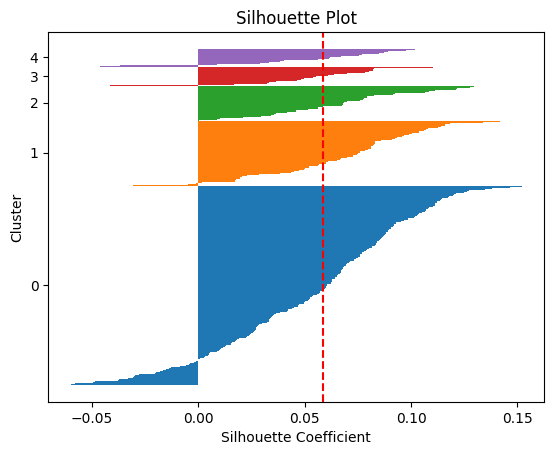

In [696]:

# Embeddings to use
embedings_x     = embeddings_MiniLM

# Selected parameters
## goof [20 40 40] [30 40 50]
## bad [20 50 60] [20 50 50] [20 30 50]
_minCluster = 10
_components = 50
_neighbors  = 30

# Fit the BERTopic model
topics, probs, topic_model = BERTopic_model(
                                sentences,
                                embedings_x, 
                                n_comp        = _components, 
                                n_neigh       = _neighbors, 
                                minS_cluster  = _minCluster,
                                )
silhouette_avg, negative_topics = silhouette_score_calc(embedings_x, topics)
print(f"Silhouette score: {silhouette_avg}")

# Plot the silhouette score
plot_silhouette_score(embedings_x, topics)

In [697]:
# Reduce embeddings to 2D for visualization
reduced_embeddings = umap.UMAP( n_neighbors=50, n_components=2, 
                          min_dist=0.0, metric='cosine').fit_transform(embeddings_MiniLM)

# Get the abstracts information from the topic model
document_info = topic_model.get_document_info(sentences)

# Visualize the topics
topic_model.visualize_documents(sentences, reduced_embeddings=reduced_embeddings, 
                                hide_document_hover=True, hide_annotations=True)

In [698]:
repr_doc = document_info[['Topic','KeyBert', 'Representative_Docs']]
repr_doc = repr_doc[repr_doc['Topic']!= -1]
repr_doc = repr_doc.drop_duplicates(subset=['Topic'])

def prompt_GPT(documents, keywords):
    
    _documents  = '- '+'\n- '.join(documents)  
    _keywords   = ', '.join(keywords)
    
    prompt = """
I have a topic that contains the following documents: 
[DOCUMENTS]

The topic is described by the following keywords: [KEYWORDS]

Based on the information above, extract a short topic label in the following format:
topic: <topic label>
"""
    return prompt.replace('[DOCUMENTS]', _documents).replace('[KEYWORDS]', _keywords)

repr_doc['Prompt'] = repr_doc.apply(lambda x: prompt_GPT(x['Representative_Docs'], x['KeyBert']), axis=1)
repr_doc.to_excel('repr_Challenges.xlsx', index=False)


In [709]:
from transformers import pipeline
summarizer = pipeline("summarization", model="facebook/bart-large-cnn", device=0)

def flexible_summarizer(text):
    length = len(text.split())
    
    if length < 30:  # Skip summarizing if the text is too short
        return []
    else:
        max_len = min(250, int(0.7 * length))  # Dynamic max length as a fraction of the text length
        min_len = min(80, int(0.7 * length))   # Dynamic min length
        return summarizer(text, max_length=max_len, min_length=min_len, do_sample=False)
    
def summarize_text(sentences):
    summary_sent = []
    for sent in sentences:
        summary = flexible_summarizer(sent)
        summary_sent.append(summary[0]['summary_text'])
    return summary_sent


sentences = repr_doc['Representative_Docs'][0]
for sent in sentences:
    print(sent)

Transport-related activities represented 34% of the total carbon emissions in the UK in 2022 and heavy-duty vehicles (HGVs) accounted for one-fifth of the road transport greenhouse gas (GHG) emissions.
In the light of ever-increasing global energy use, the increasing cost of energy services, concerns over energy supply security, climate change and local air pollution, this book centres around the question of how growing energy demand for transport can be met in the long term.
Despite this uncertainty, little work has been done on understanding how these factors will affect each other, particularly the timing and uptake of automated vehicles and their effect on future transport related GHG emissions and economics, yet the impact on transport policy, infrastructure and society will be profound and should be of interest to policy makers, the automotive and energy industries, and society as a whole.
